In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [202]:
data = pd.read_csv('ProjectPH.csv', usecols = [i for i in range(1,7)], index_col=0, parse_dates= True)
data['created'] = pd.to_datetime(data.index)


## ['[effacé]', '[supprimé]', 'Title', 'title', 'Title.']
to_delete = np.array(data.selftext.value_counts().index[0:5])
posts_to_delete_filter = data.selftext.isin(to_delete)
print(f'#deleted: {np.sum(posts_to_delete_filter)]}, #rows:{data.shape[0]}, %deleted: {np.sum(posts_to_delete_filter)/data.shape[0]}')
data = data[~posts_to_delete_filter]

# date_time_format = '%Y-%m-%d %H:%M:%S'

## create df per day
dates = np.sort(np.unique(data.created.dt.date))
mean_per_day = data.groupby(data.index.date).mean()

data_per_day = pd.DataFrame({"day": dates, "polarity": mean_per_day.sentiment_polarity, "subjectivity": mean_per_day.sentiment_subjectivity})
data_per_day.index, data_per_day.day = pd.DatetimeIndex(data_per_day.index), pd.to_datetime(data_per_day.index)
data_per_day.head()

19380 51036 0.3797319539148836


In [290]:
month_day_vector = pd.to_datetime([f"2020-{str(month)}-{str(day)}" for day, month in zip(data.index.day, data.index.month)])
month_day_uniques = month_day_vector.unique().sort_values(ascending=1)

polarity_mean_per_day = []
for month_day in month_day_uniques:
    filter_same_month_and_day = np.logical_and(data.index.day == month_day.day, data.index.month ==  month_day.month)
    polarity_mean_per_day.append(np.sum(data[filter_same_month_and_day].sentiment_polarity)/np.sum(filter_same_month_and_day))


sentiment_per_month = data.sentiment_polarity.groupby(data.index.month).mean()

In [295]:
print(month_day_uniques.shape ,np.array(polarity_mean_per_day).shape)

(366,) (366,)


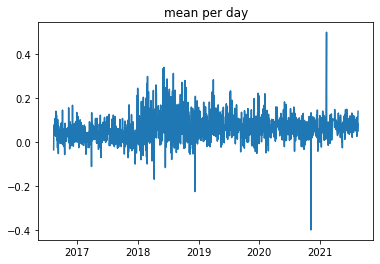

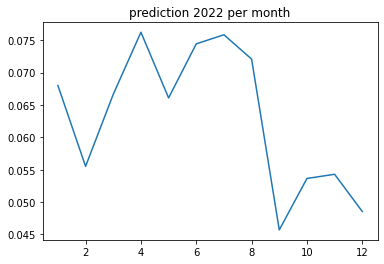

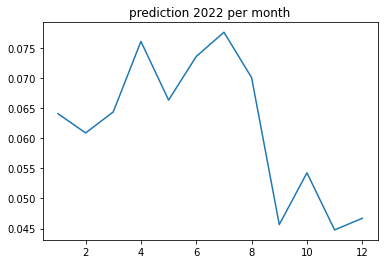

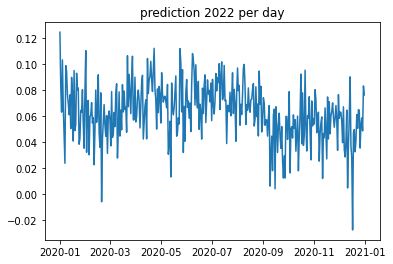

In [297]:
plt.plot(data_per_day.index.date, data_per_day.polarity)
plt.title("mean per day")
plt.show()

plt.plot(months, sentiment_per_month)
plt.title("prediction 2022 per month")
plt.show()
plt.plot(months, data_per_day.groupby(data_per_day.index.month).polarity.mean())
plt.title("prediction 2022 per month")
plt.show()
plt.plot(month_day_uniques, polarity_mean_per_day)
plt.title("prediction 2022 per day")
plt.show()

In [208]:
month_day_uniques

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=366, freq=None)